# analyze track bias (for any variable)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from datetime import datetime, timedelta
import os
import pickle

import helper_functions

In [2]:
import matplotlib
matplotlib.style.use('default')

# read data

In [3]:
# note: 'load_from_pickle' is defined in helper_functions.py
[ERA5_ECMWF, 
 ERA5_IITM, 
 ERA5_ECMWF_deps, 
 ERA5_ECMWF_lows,
 ERA5_IITM_deps, 
 ERA5_IITM_lows] = helper_functions.load_from_pickle('data/update/models_joined_with_era5.pickle')

In [4]:
[MERRA2_ECMWF,
 MERRA2_IITM] = helper_functions.load_from_pickle('data/update/models_joined_with_merra2.pickle')

In [5]:
len(MERRA2_IITM), len(MERRA2_ECMWF)

(94, 103)

# Helper methods to wrangle data in preparation for plotting

In [ ]:
# use this to get a df with bias for 'var' by forecast lead time. 
# DO NOT USE for position bias (use the method below this)
# add_leadtime_column, add_bias_columns, concat_bias and group_on_leadtime are defined
#    in helper_functions.py

def create_lead_time_vs_bias_df(orig_dic, model_name, observation_name, var, relative=False):
    
    if relative==True:
        dic_with_leadtime = helper_functions.add_leadtime_column(orig_dic)
        dic_with_bias = helper_functions.add_bias_columns(dic_with_leadtime, model_name, 
                                                          observation_name, var, 
                                                          relative=True)
        concatted_df = helper_functions.concat_bias(dic_with_bias, model_name, 
                                                    observation_name, var,
                                                    relative=True)
        grouped_df = helper_functions.group_on_leadtime(concatted_df)

        return grouped_df[var+'Bias'].reset_index(), grouped_df['Relative'+var+'Bias'].reset_index()
    
    else:
        dic_with_leadtime = helper_functions.add_leadtime_column(orig_dic)
        dic_with_bias = helper_functions.add_bias_columns(dic_with_leadtime, model_name, 
                                                          observation_name, var)
        concatted_df = helper_functions.concat_bias(dic_with_bias, model_name, 
                                                    observation_name, var)
        grouped_df = helper_functions.group_on_leadtime(concatted_df)

        return grouped_df[var+'Bias'].reset_index()

In [8]:
# use this to get a df with bias for 'var' by forecast lead time
# add_leadtime_column, add_position_bias_columns, concat_bias and group_on_leadtime are defined
#    in helper_functions.py

def create_lead_time_vs_position_bias_df(orig_dic, model_name, observation_name):
    
    dic_with_leadtime = helper_functions.add_leadtime_column(orig_dic)
    dic_with_bias = helper_functions.add_position_bias_columns(dic_with_leadtime, model_name, 
                                                               observation_name)
    concatted_df = helper_functions.concat_bias(dic_with_bias, model_name, 
                                                observation_name, var='Distance')
    grouped_df = helper_functions.group_on_leadtime(concatted_df)
    
    return grouped_df['DistanceBias'].reset_index()

# Helper methods to create plots

In [9]:
# makes a scatter plot of xvalue and yvalue and shades the region between fillbetween_low
#    and fillbetween_high

# example of use:
# plot_on_ax(ax, df, xvalue='ForecastLeadTime', yvalue='mean', color_var='count', 
#            label='IITM bias', 
#            fillbetween_low='<lambda_0>', fillbetween_high='<lambda_1>', 
#            plot_colors={'color': 'b'})
# Note: <lambda_0> and <lambda_1> are the names Python automatically assigned to the
#    10th and 90th percentiles
# divide=100 means divide y-values by 100

def plot_on_ax(ax, df, xvalue, yvalue, color_var, label, fillbetween_low, fillbetween_high,
               plot_colors={}, fill_colors={}, divide=False):
    
    # points = ax.scatter(x=df[xvalue], y=df[yvalue],)
    #                 c=df[color_var], cmap = 'copper_r') # Suhas said skip this
    points = 2 # random placeholder
    
    if not divide:
        ax.plot(df[xvalue], df[yvalue], label=label, **plot_colors) # toggle /100 for intensity bias

        # add label=fill_label if desired
        ax.fill_between(df[xvalue], y1=df[fillbetween_low], y2=df[fillbetween_high],
                        alpha=0.2, **fill_colors)
    
    else:
        ax.plot(df[xvalue], df[yvalue]/divide, label=label, **plot_colors) # toggle /100 for intensity bias

        # add label=fill_label if desired
        ax.fill_between(df[xvalue], y1=df[fillbetween_low]/divide, y2=df[fillbetween_high]/divide,
                        alpha=0.2, **fill_colors)
    
    return points

In [10]:
# formats an axes element so that the x-axis has units of hours but
#    the x-ticks are shown daily for 10 days (i.e. once every 24 hours, for 240 hours total)

def format_ax(ax, title, ymin, ymax, yaxislabel, ax_label, yax=True, legend_loc=None):
    ax.set_xticks(np.arange(0, 145, 24)) # daily
    ax.plot([0, 144], [0,0], 'black')
    ax.grid()
    ax.set_ylim([ymin, ymax])
    ax.set_xlim([0, 144]) # changed from 240
    ax.set_xlabel("Forecast lead time (h)", size=18, fontname='Dejavu Sans')
    if yax==True:
        ax.set_ylabel(yaxislabel, labelpad=10, size=18, fontname='Dejavu Sans')
    ax.tick_params(axis='both', labelsize=14)
    ax.set_title(title, size=16, fontname='Dejavu Sans')
    ax.annotate(ax_label, xy=(0, 1.025), xycoords='axes fraction', fontname='Dejavu Sans', 
                fontsize=16)
    if legend_loc:
        ax.legend(prop={'size': 16}, loc=legend_loc)
    else:
        ax.legend(prop={'size': 16})

In [11]:
# pass in the output from create_lead_time_vs_bias_df
# plots lead time vs. bias for one model

# example of use:
# ERA5_IITM_grouped = create_lead_time_vs_position_bias_df(ERA5_IITM, 'iitm', 'era5')
# fig, ax = plt.subplots(figsize=(9,4.8))
# plot_lead_time_vs_bias(ax, ERA5_IITM_grouped, 
#                        xvalue='ForecastLeadTime', 
#                        yvalue='mean', 
#                        color_var='count', 
#                        label='IITM bias', 
#                        median='median',
#                        yvalue_std='std', 
#                        fillbetween_low='<lambda_0>', fillbetween_high='<lambda_1>', 
#                        title='lead time vs. bias', 
#                        ymin=0, ymax=1600,
#                        yaxislabel='Position bias (km)')

def plot_lead_time_vs_bias(ax, df, xvalue, yvalue, 
                      color_var, label, median, yvalue_std, 
                      fillbetween_low, fillbetween_high,
                      title, ymin, ymax, yaxislabel):
    
    points = plot_on_ax(ax, df, xvalue, yvalue, color_var, 
                        label, fillbetween_low, fillbetween_high,
                        plot_colors={'color': 'C0'}, fill_colors={'color': 'C1'}) 
    # plt.colorbar(points).set_label('Number of Systems') # Suhas said skip this for now
    
    ax.plot(df[xvalue], df[median], linestyle='-')
    ax.errorbar(x=df[xvalue], y=df[yvalue], yerr=df[yvalue_std])
    
    format_ax(ax, title, ymin, ymax, yaxislabel)
    
    plt.show()

In [66]:
# to compare the bias of two models against each other
# if you pass in a df=create_lead_time_vs_bias_df to this method, 
#    instead you need to pass df['DistanceBias'].reset_index()

# example of use:
# df1 = create_lead_time_vs_position_bias_df(ERA5_ECMWF, 'ecmwf', 'era5')
# df2 = create_lead_time_vs_position_bias_df(ERA5_IITM, 'iitm', 'era5')

# fig, ax = plt.subplots(figsize=(9,4.8))
# lead_time_vs_bias_compare_models(ax, df1, df2,
#                           xvalue='ForecastLeadTime',
#                           yvalue='mean',
#                           color_var='count',
#                           label_model1='ECMWF', label_model2='IITM',
#                           fillbetween_low='<lambda_0>', fillbetween_high='<lambda_1>')

def lead_time_vs_bias_compare_models(ax, df1, df2, xvalue, yvalue, color_var, 
                                     label_model1, label_model2,
                                     fillbetween_low, fillbetween_high,
                                     title, ymin, ymax, yaxislabel,
                                     ax_label, yax=True, legend_loc=None, divide=False):
    
    points = plot_on_ax(ax, df1, xvalue, yvalue, color_var, label_model1, fillbetween_low,
               fillbetween_high, plot_colors={'color': 'C0'}, fill_colors={'color': 'C0'},
                       divide=divide)
    points = plot_on_ax(ax, df2, xvalue, yvalue, color_var, label_model2, fillbetween_low,
               fillbetween_high, plot_colors={'color': 'C1'}, fill_colors={'color': 'C1'},
                       divide=divide)
    
    #plt.colorbar(points).set_label('Number of Systems')
    
    #title="Comparison of Forecast Lead Time vs. Track Position Bias"
    #yaxislabel="Position bias (km)"
    format_ax(ax, title=title, ymin=ymin, ymax=ymax, yaxislabel=yaxislabel, ax_label=ax_label, yax=yax,
             legend_loc=legend_loc)

In [67]:
# 2-panel comparison of model1 vs. model2, but with different variables in each panel

def two_panel_comparison(ax1, ax2, df1_ax1, df2_ax1, df1_ax2, df2_ax2,
                        xvalue, yvalue1, yvalue2,
                        color_var,
                        label_df1_ax1, label_df2_ax1,
                        label_df1_ax2, label_df2_ax2,
                        fillbetween_low, fillbetween_high,
                        title_ax1, title_ax2,
                        ymin_ax1, ymax_ax1, ymin_ax2, ymax_ax2,
                        yaxislabel_ax1, yaxislabel_ax2,
                        show_both_yax=False,
                        legend_loc=None,
                        divide_ax1=False, divide_ax2=False):
    
    # points_df1_ax1 = plot_on_ax(ax1, df1_ax1, xvalue, yvalue,  color_var, label_df1_ax1,
    #                                fillbetween_low, fillbetween_high)
    # points_df2_ax1 = plot_on_ax(ax1, df2_ax1, xvalue, yvalue,  color_var, label_df2_ax1,
    #                                fillbetween_low, fillbetween_high)
    # plt.colorbar(points_df1_ax1, ax=ax1).set_label("Number of Systems")
    # format_ax(ax1, title_ax1, ymin=ymin, ymax=ymax, yaxislabel=yaxislabel)
    
    lead_time_vs_bias_compare_models(ax1, df1_ax1, df2_ax1, xvalue, yvalue1, color_var,
                                     label_df1_ax1, label_df2_ax1, 
                                     fillbetween_low, fillbetween_high,
                                     title_ax1, ymin_ax1, ymax_ax1, yaxislabel_ax1,
                                     '(a)', legend_loc=legend_loc, divide=divide_ax1)
    
    lead_time_vs_bias_compare_models(ax2, df1_ax2, df2_ax2, xvalue, yvalue2, color_var,
                                     label_df1_ax2, label_df2_ax2, 
                                     fillbetween_low, fillbetween_high,
                                     title_ax2, ymin_ax2, ymax_ax2, yaxislabel_ax2,
                                     '(b)', yax=show_both_yax,
                                     legend_loc=legend_loc, divide=divide_ax2) # toggle as needed
    
    
    
    

In [44]:
# 3-panel figure of model1 vs. model2 overall, model1 depressions vs. lows, 
#    and model2 depressions vs. lows

# example of use:
# ERA5_ECMWF_grouped = create_lead_time_vs_position_bias_df(ERA5_ECMWF, 'ecmwf', 'era5')
# ERA5_IITM_grouped = create_lead_time_vs_position_bias_df(ERA5_IITM, 'iitm', 'era5')
# ERA5_ECMWF_deps_grouped = create_lead_time_vs_position_bias_df(ERA5_ECMWF_deps, 'ecmwf', 'era5')
# ERA5_ECMWF_lows_grouped = create_lead_time_vs_position_bias_df(ERA5_ECMWF_lows, 'ecmwf', 'era5')
# ERA5_IITM_deps_grouped = create_lead_time_vs_position_bias_df(ERA5_IITM_deps, 'iitm', 'era5')
# ERA5_IITM_lows_grouped = create_lead_time_vs_position_bias_df(ERA5_IITM_lows, 'iitm', 'era5')

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,4.8))
# df1, df2 = ERA5_ECMWF_grouped, ERA5_IITM_grouped
# df1_deps, df1_lows = ERA5_ECMWF_deps_grouped, ERA5_ECMWF_lows_grouped
# df2_deps, df2_lows = ERA5_IITM_deps_grouped, ERA5_IITM_lows_grouped

# compare_lead_time_vs_bias_with_deps_lows(ax1, ax2, ax3, df1, df2, df1_deps, df1_lows, 
#                                          df2_deps, df2_lows,
#                                          xvalue='ForecastLeadTime', yvalue='mean', 
#                                          color_var='count', 
#                                          fillbetween_low='<lambda_0>', 
#                                          fillbetween_high='<lambda_1>',
#                                          ymin=0, ymax=1600, yaxislabel='Position bias (km)',
#                                          label_model1='ECMWF', label_model2='IITM',
#                                          label_model1_deps='ECMWF depressions', 
#                                          label_model1_lows='ECMWF lows',
#                                          label_model2_deps = 'IITM depressions', 
#                                          label_model2_lows='IITM lows',
#                                          title_ax1='Forecast Lead Time vs. Track Position Bias',
#                                          title_ax2='Position Bias for ECMWF depressions vs. lows',
#                                          title_ax3='Position Bias for IITM depressions vs. lows')

def compare_lead_time_vs_bias_with_deps_lows(ax1, ax2, ax3, df1, df2, 
                                             df1_deps, df1_lows, df2_deps, df2_lows,
                                             xvalue, yvalue, color_var, 
                                             fillbetween_low, fillbetween_high,
                                             ymin, ymax, yaxislabel,
                                             label_model1, label_model2,
                                             label_model1_deps, label_model1_lows,
                                             label_model2_deps, label_model2_lows,
                                             title_ax1, title_ax2, title_ax3,
                                             legend_loc=None,
                                             divide_ax1=False, divide_ax2=False, divide_ax3=False):

    # model1 vs. model2
    
    points_model1 = plot_on_ax(ax1, df1, xvalue, yvalue, color_var, label_model1, fillbetween_low,
               fillbetween_high, plot_colors={'color': 'C0'}, divide=divide_ax1)
    
    points_model2 = plot_on_ax(ax1, df2, xvalue, yvalue, color_var, label_model2, fillbetween_low,
               fillbetween_high, plot_colors={'color': 'C1'}, divide=divide_ax1)
    
    # plt.colorbar(points_model1, ax=ax1).set_label("Number of Systems") # Suhas said skip
    format_ax(ax1, title_ax1, ymin=ymin, ymax=ymax, yaxislabel=yaxislabel, ax_label='(a)',
             legend_loc=legend_loc)

    # model1 depressions vs. lows
    
    points_model1_deps = plot_on_ax(ax2, df1_deps, xvalue, yvalue, color_var, label_model1_deps, 
                                    fillbetween_low, fillbetween_high,
                                    plot_colors={'color': 'C2'},
                                    fill_colors={'color': 'C2'},
                                    divide=divide_ax2)
                                    # plot_colors={'color': 'purple'},
                                    # fill_colors={'color': 'purple'})
    
    points_model1_lows = plot_on_ax(ax2, df1_lows, xvalue, yvalue, color_var, label_model1_lows, 
                                    fillbetween_low, fillbetween_high,
                                    plot_colors={'color': 'C3'},
                                    fill_colors={'color': 'C3'},
                                    divide=divide_ax2)
                                    # plot_colors={'color': 'green'},
                                    # fill_colors={'color': 'green'})
    
    # plt.colorbar(points_model1_deps, ax=ax2).set_label("Number of Systems") # Suhas said skip
    # yax=False since all yaxes have the same label, only put it on ax1
    format_ax(ax2, title_ax2, ymin=ymin, ymax=ymax, yaxislabel=yaxislabel, ax_label='(b)', yax=False,
             legend_loc=legend_loc)

    # model2 depressions vs. lows
    
    points_model2_deps = plot_on_ax(ax3, df2_deps, xvalue, yvalue, color_var, label_model2_deps, 
                                    fillbetween_low, fillbetween_high,
                                    plot_colors={'color': 'C2'},
                                    fill_colors={'color': 'C2'},
                                    divide=divide_ax3)
                                    # plot_colors={'color': 'purple'},
                                    # fill_colors={'color': 'purple'})
    
    points_model2_lows = plot_on_ax(ax3, df2_lows, xvalue, yvalue, color_var, label_model2_lows, 
                                    fillbetween_low, fillbetween_high,
                                    plot_colors={'color': 'C3'},
                                    fill_colors={'color': 'C3'},
                                    divide=divide_ax3)
                                    # plot_colors={'color': 'green'},
                                    # fill_colors={'color': 'green'})

    # plt.colorbar(points_model2_deps, ax=ax3).set_label("Number of Systems") # Suhas said skip
    format_ax(ax3, title_ax3, ymin=ymin, ymax=ymax, yaxislabel=yaxislabel, ax_label='(c)', yax=False,
             legend_loc=legend_loc)

    #plt.savefig("Figures/lead_time_vs_position_bias.pdf", format='pdf', bbox_inches='tight')

# Helper methods to check difference-of-means significance

In [15]:
from scipy.stats import mannwhitneyu

In [16]:
def mann_whitney_position_df(orig_dic, model_name, observation_name):
    
    dic_with_leadtime = helper_functions.add_leadtime_column(orig_dic)
    dic_with_bias = helper_functions.add_position_bias_columns(dic_with_leadtime, model_name, 
                                                               observation_name)
    concatted_df = helper_functions.concat_bias(dic_with_bias, model_name, observation_name, 'Distance')
    
    return concatted_df.dropna()

In [28]:
# use this to get a df with bias for 'var' by forecast lead time
# add_leadtime_column, add_bias_columns, concat_bias and group_on_leadtime are defined
#    in helper_functions.py

def mann_whitney_bias_df(orig_dic, model_name, observation_name, var):
    
    dic_with_leadtime = helper_functions.add_leadtime_column(orig_dic)
    dic_with_bias = helper_functions.add_bias_columns(dic_with_leadtime, model_name, 
                                                      observation_name, var)
    concatted_df = helper_functions.concat_bias(dic_with_bias, model_name, observation_name, var)

    return concatted_df.dropna()

In [17]:
def mann_whitney_output(df1, df2, var):
    
    #times_hourly = [i for i in range(0, 241, 6)]
    times_daily = [(x,y) for x,y in zip(range(0, 241, 24), range(24, 241, 24))]
    
    pvalues = [mannwhitneyu(df1[df1['ForecastLeadTime'].between(x,y,inclusive="left")][var],
                            df2[df2['ForecastLeadTime'].between(x,y,inclusive="left")][var]) 
               for (x,y) in times_daily]
    
    return pvalues

# FORECAST LEAD TIME VS. TRACK POSITION BIAS

## models vs. ERA5

In [70]:
ERA5_ECMWF_grouped = create_lead_time_vs_position_bias_df(ERA5_ECMWF, 'ecmwf', 'era5')
ERA5_IITM_grouped = create_lead_time_vs_position_bias_df(ERA5_IITM, 'iitm', 'era5')

In [71]:
ERA5_ECMWF_deps_grouped = create_lead_time_vs_position_bias_df(ERA5_ECMWF_deps, 'ecmwf', 'era5')
ERA5_ECMWF_lows_grouped = create_lead_time_vs_position_bias_df(ERA5_ECMWF_lows, 'ecmwf', 'era5')

In [72]:
ERA5_IITM_deps_grouped = create_lead_time_vs_position_bias_df(ERA5_IITM_deps, 'iitm', 'era5')
ERA5_IITM_lows_grouped = create_lead_time_vs_position_bias_df(ERA5_IITM_lows, 'iitm', 'era5')

### plots

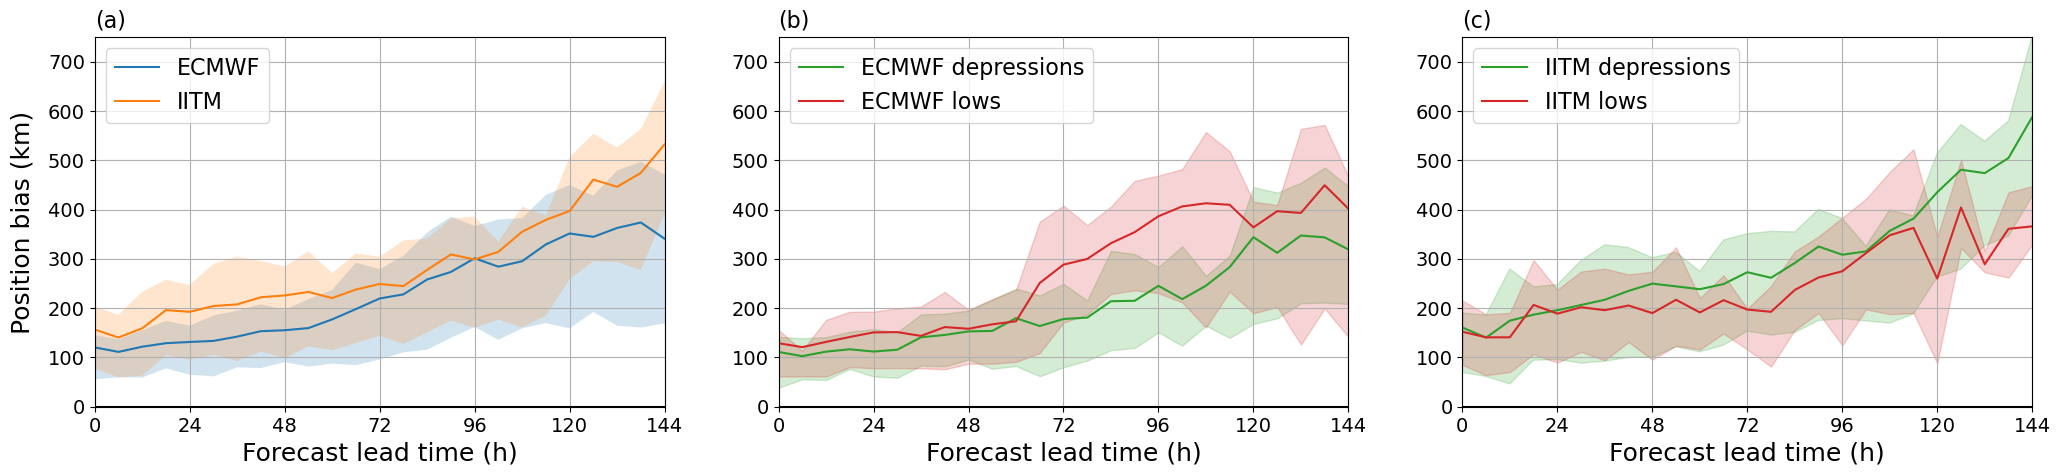

In [74]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,4.8))

df1, df2 = ERA5_ECMWF_grouped, ERA5_IITM_grouped
df1_deps, df1_lows = ERA5_ECMWF_deps_grouped, ERA5_ECMWF_lows_grouped
df2_deps, df2_lows = ERA5_IITM_deps_grouped, ERA5_IITM_lows_grouped

compare_lead_time_vs_bias_with_deps_lows(ax1, ax2, ax3, df1, df2, df1_deps, df1_lows, 
                                         df2_deps, df2_lows,
                                         xvalue='ForecastLeadTime', yvalue='mean', 
                                         color_var='count', 
                                         fillbetween_low='<lambda_0>', 
                                         fillbetween_high='<lambda_1>',
                                         ymin=0, ymax=750, yaxislabel='Position bias (km)',
                                         label_model1='ECMWF', label_model2='IITM',
                                         label_model1_deps='ECMWF depressions', 
                                         label_model1_lows='ECMWF lows',
                                         label_model2_deps = 'IITM depressions', 
                                         label_model2_lows='IITM lows',
                                         title_ax1=None,
                                         title_ax2=None,
                                         title_ax3=None,
                                         legend_loc='upper left')
                                         # title_ax1='Forecast Lead Time vs. Track Position Bias',
                                         # title_ax2='Position Bias for ECMWF depressions vs. lows',
                                         # title_ax3='Position Bias for IITM depressions vs. lows')

# fig.suptitle('Position bias comparisons for models vs. ERA5', fontsize=24, y=1.05) # Suhas: skip
# plt.savefig('Figures/figures_08212022/lead_time_vs_position_bias.pdf', 
#             format='pdf', bbox_inches='tight')

### checking significance

In [26]:
ERA5_ECMWF_test = mann_whitney_position_df(ERA5_ECMWF, 'ecmwf', 'era5')
ERA5_IITM_test = mann_whitney_position_df(ERA5_IITM, 'iitm', 'era5')

In [28]:
mann_whitney_output(ERA5_ECMWF_test, ERA5_IITM_test, 'DistanceBias')

[MannwhitneyuResult(statistic=93177.5, pvalue=1.351207080162005e-09),
 MannwhitneyuResult(statistic=74785.5, pvalue=2.0666772338521235e-11),
 MannwhitneyuResult(statistic=46707.5, pvalue=3.727474855559048e-05),
 MannwhitneyuResult(statistic=28454.0, pvalue=0.16003772299714036),
 MannwhitneyuResult(statistic=12279.0, pvalue=0.10198540941347611),
 MannwhitneyuResult(statistic=4411.0, pvalue=0.0003412072421266361),
 MannwhitneyuResult(statistic=1397.0, pvalue=8.822906855941292e-07),
 MannwhitneyuResult(statistic=638.0, pvalue=0.001029694127833294),
 MannwhitneyuResult(statistic=253.0, pvalue=0.01925191959279504),
 MannwhitneyuResult(statistic=31.0, pvalue=0.12770439022573515)]

# FORECAST LEAD TIME VS. TRACK INTENSITY BIAS

#### Note: 'intensity' corresponds to the variable 'PressureDrop'

## models vs. ERA5

In [18]:
ERA5_ECMWF_intensity_bias, ERA5_ECMWF_rel_intensity_bias = \
    create_lead_time_vs_bias_df(ERA5_ECMWF, 'ecmwf', 'era5', var='PressureDrop', relative=True)

ERA5_IITM_intensity_bias, ERA5_IITM_rel_intensity_bias = \
    create_lead_time_vs_bias_df(ERA5_IITM, 'iitm', 'era5', var='PressureDrop', relative=True)

In [19]:
ERA5_ECMWF_deps_intensity_bias = create_lead_time_vs_bias_df(ERA5_ECMWF_deps, 'ecmwf', 'era5',
                                                             var='PressureDrop')
ERA5_ECMWF_lows_intensity_bias = create_lead_time_vs_bias_df(ERA5_ECMWF_lows, 'ecmwf', 'era5',
                                                             var='PressureDrop')

In [20]:
ERA5_IITM_deps_intensity_bias = create_lead_time_vs_bias_df(ERA5_IITM_deps, 'iitm', 'era5',
                                                            var='PressureDrop')
ERA5_IITM_lows_intensity_bias = create_lead_time_vs_bias_df(ERA5_IITM_lows, 'iitm', 'era5',
                                                            var='PressureDrop')

### plots

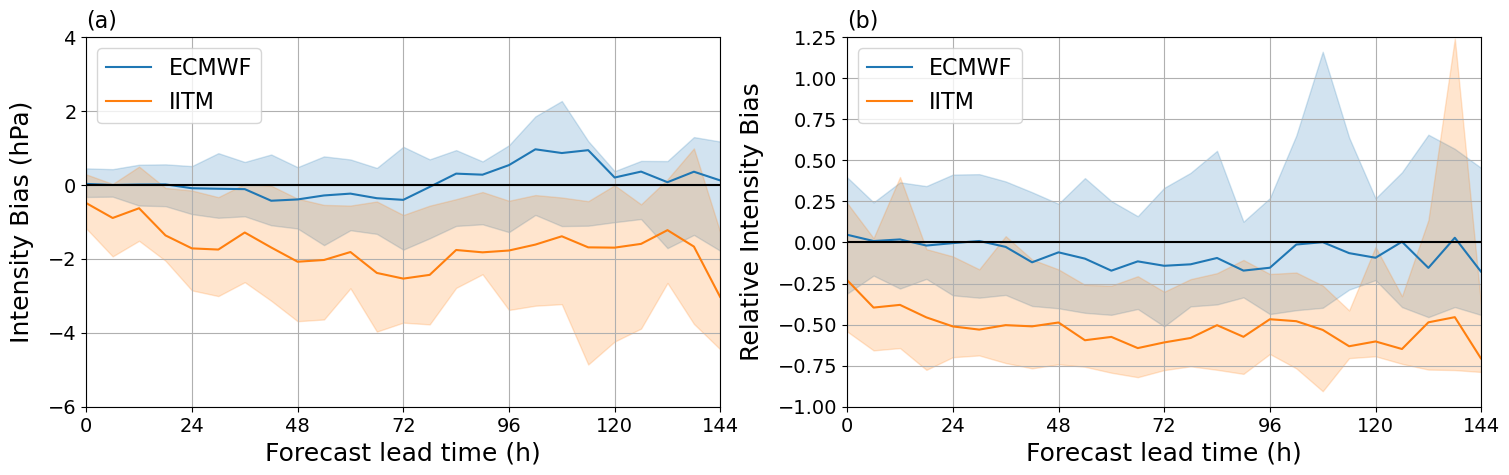

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,4.8))
two_panel_comparison(ax1, ax2,
                     df1_ax1 = ERA5_ECMWF_intensity_bias,
                     df2_ax1 = ERA5_IITM_intensity_bias,
                     df1_ax2 = ERA5_ECMWF_rel_intensity_bias,
                     df2_ax2 = ERA5_IITM_rel_intensity_bias,
                     xvalue='ForecastLeadTime', yvalue1='mean', yvalue2='median',
                     color_var='count',
                     label_df1_ax1='ECMWF', label_df2_ax1='IITM',
                     label_df1_ax2='ECMWF', label_df2_ax2='IITM',
                     fillbetween_low='<lambda_0>', fillbetween_high='<lambda_1>',
                     title_ax1=None,
                     title_ax2=None,
                     # title_ax1='Forecast Lead Time vs. Track Intensity Bias', 
                     # title_ax2='Forecast Lead Time vs. Rel. Track Intensity Bias',
                     ymin_ax1=-6, ymax_ax1=4, 
                     ymin_ax2=-1, ymax_ax2=1.25, 
                     yaxislabel_ax1='Intensity Bias (hPa)', yaxislabel_ax2='Relative Intensity Bias',
                     legend_loc='upper left',
                     show_both_yax=True,
                     divide_ax1=100, divide_ax2=False)

# fig.suptitle('Intensity bias comparisons for models vs. ERA5', 
#              fontsize=24, y=1.05)
# plt.savefig('Figures/figures_08212022/lead_time_vs_intensity_bias.pdf', 
#             format='pdf', bbox_inches='tight')

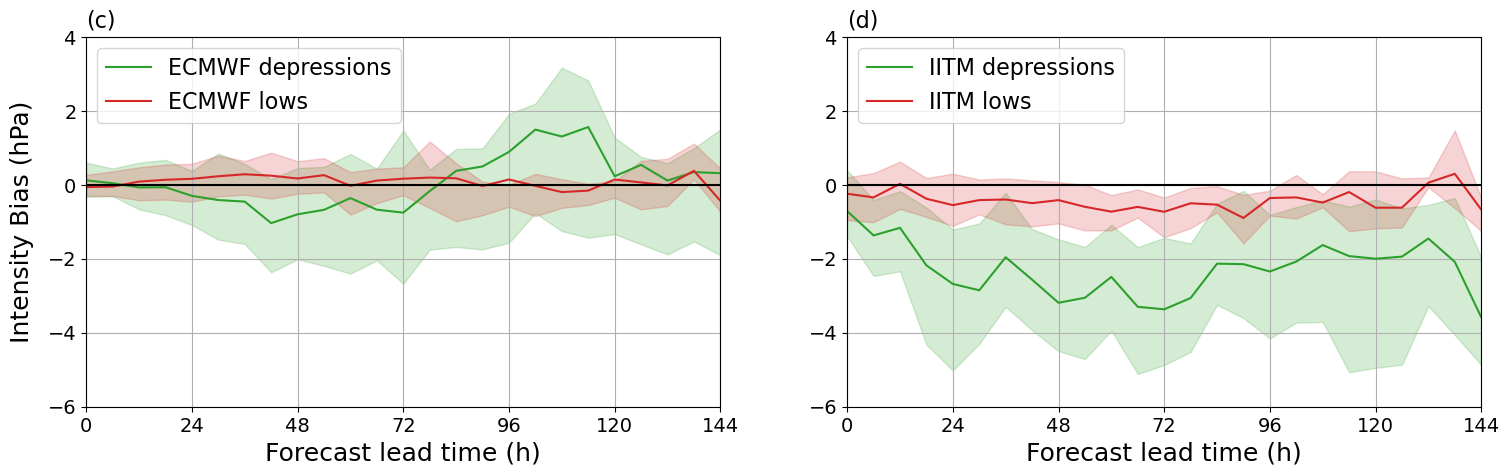

In [65]:
# manually went up into helper plotting functions and changed C0 and C1 colors to C2 and C3
# and manually changed the labels to (c) and (d)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,4.8))
two_panel_comparison(ax1, ax2,
                     df1_ax1 = ERA5_ECMWF_deps_intensity_bias,
                     df2_ax1 = ERA5_ECMWF_lows_intensity_bias,
                     df1_ax2 = ERA5_IITM_deps_intensity_bias,
                     df2_ax2 = ERA5_IITM_lows_intensity_bias,
                     xvalue='ForecastLeadTime', yvalue1='mean', yvalue2='mean',
                     color_var='count',
                     label_df1_ax1='ECMWF depressions', label_df2_ax1='ECMWF lows',
                     label_df1_ax2='IITM depressions', label_df2_ax2='IITM lows',
                     fillbetween_low='<lambda_0>', fillbetween_high='<lambda_1>',
                     title_ax1=None,
                     title_ax2=None,
                     # title_ax1='Forecast Lead Time vs. Mean Track Intensity Bias', 
                     # title_ax2='Forecast Lead Time vs. Mean Track Intensity Bias',
                     ymin_ax1=-6, ymax_ax1=4, 
                     ymin_ax2=-6, ymax_ax2=4, 
                     yaxislabel_ax1='Intensity Bias (hPa)', yaxislabel_ax2='Intensity Bias (hPa)',
                     legend_loc='upper left',
                     divide_ax1=100, divide_ax2=100)

# fig.suptitle('Intensity bias comparisons for depressions and lows', 
#              fontsize=24, y=1.05)
# plt.savefig('Figures/figures_08212022/lead_time_vs_intensity_bias_depslows.pdf', 
#             format='pdf', bbox_inches='tight')

### checking significance

In [29]:
ERA5_ECMWF_intensity_test = mann_whitney_bias_df(ERA5_ECMWF, 'ecmwf', 'era5', 'PressureDrop')
ERA5_IITM_intensity_test = mann_whitney_bias_df(ERA5_IITM, 'iitm', 'era5', 'PressureDrop')

In [30]:
mann_whitney_output(ERA5_ECMWF_intensity_test, ERA5_IITM_intensity_test, 'PressureDropBias')

[MannwhitneyuResult(statistic=76600.0, pvalue=1.4823206475045057e-22),
 MannwhitneyuResult(statistic=60345.0, pvalue=2.850018001494915e-25),
 MannwhitneyuResult(statistic=33378.0, pvalue=1.3028676690868328e-20),
 MannwhitneyuResult(statistic=17831.5, pvalue=4.304312721725164e-15),
 MannwhitneyuResult(statistic=7932.0, pvalue=1.2116080530245424e-10),
 MannwhitneyuResult(statistic=3813.0, pvalue=1.52377003958635e-06),
 MannwhitneyuResult(statistic=931.0, pvalue=1.8546985190341756e-11),
 MannwhitneyuResult(statistic=326.0, pvalue=1.678593473622151e-08),
 MannwhitneyuResult(statistic=233.0, pvalue=0.008274002292794892),
 MannwhitneyuResult(statistic=45.0, pvalue=0.44347533974985826)]

# FORECAST LEAD TIME VS. TRACK WIND SPEED BIAS

In [31]:
ERA5_ECMWF_windspeed_bias, ERA5_ECMWF_rel_windspeed_bias = \
    create_lead_time_vs_bias_df(ERA5_ECMWF, 'ecmwf', 'era5', var='MaxSfcWind', relative=True)

ERA5_IITM_windspeed_bias, ERA5_IITM_rel_windspeed_bias = \
    create_lead_time_vs_bias_df(ERA5_IITM, 'iitm', 'era5', var='MaxSfcWind', relative=True)

In [32]:
ERA5_ECMWF_deps_windspeed_bias = create_lead_time_vs_bias_df(ERA5_ECMWF_deps, 'ecmwf', 'era5',
                                                             var='MaxSfcWind')
ERA5_ECMWF_lows_windspeed_bias = create_lead_time_vs_bias_df(ERA5_ECMWF_lows, 'ecmwf', 'era5',
                                                             var='MaxSfcWind')

In [33]:
ERA5_IITM_deps_windspeed_bias = create_lead_time_vs_bias_df(ERA5_IITM_deps, 'iitm', 'era5',
                                                            var='MaxSfcWind')
ERA5_IITM_lows_windspeed_bias = create_lead_time_vs_bias_df(ERA5_IITM_lows, 'iitm', 'era5',
                                                            var='MaxSfcWind')

### plots

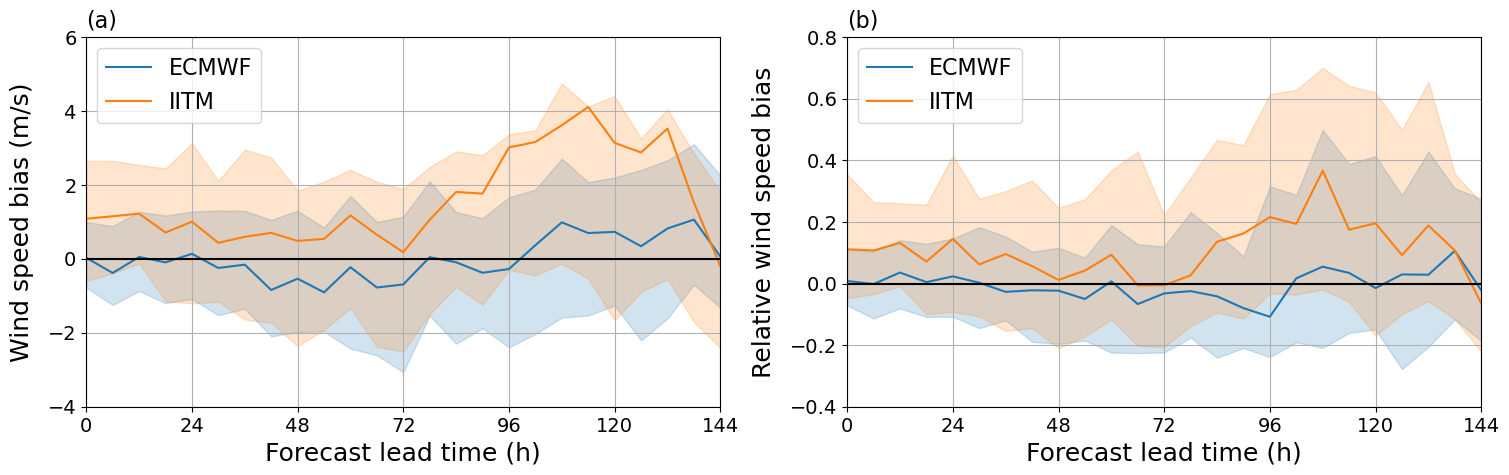

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,4.8))
two_panel_comparison(ax1, ax2,
                     df1_ax1 = ERA5_ECMWF_windspeed_bias,
                     df2_ax1 = ERA5_IITM_windspeed_bias,
                     df1_ax2 = ERA5_ECMWF_rel_windspeed_bias,
                     df2_ax2 = ERA5_IITM_rel_windspeed_bias,
                     xvalue='ForecastLeadTime', yvalue1='mean', yvalue2='median',
                     color_var='count',
                     label_df1_ax1='ECMWF', label_df2_ax1='IITM',
                     label_df1_ax2='ECMWF', label_df2_ax2='IITM',
                     fillbetween_low='<lambda_0>', fillbetween_high='<lambda_1>',
                     title_ax1=None,
                     title_ax2=None,
                     # title_ax1='Forecast Lead Time vs. Mean Track Wind Speed Bias', 
                     # title_ax2='Forecast Lead Time vs. Median Relative Track Wind Speed Bias',
                     ymin_ax1=-4, ymax_ax1=6, 
                     ymin_ax2=-0.4, ymax_ax2=.8, 
                     yaxislabel_ax1='Wind speed bias (m/s)', yaxislabel_ax2='Relative wind speed bias',
                     show_both_yax=True,
                     legend_loc='upper left')

# plt.savefig('Figures/figures_08212022/lead_time_vs_windspeed_bias.pdf', 
#             format='pdf', bbox_inches='tight')

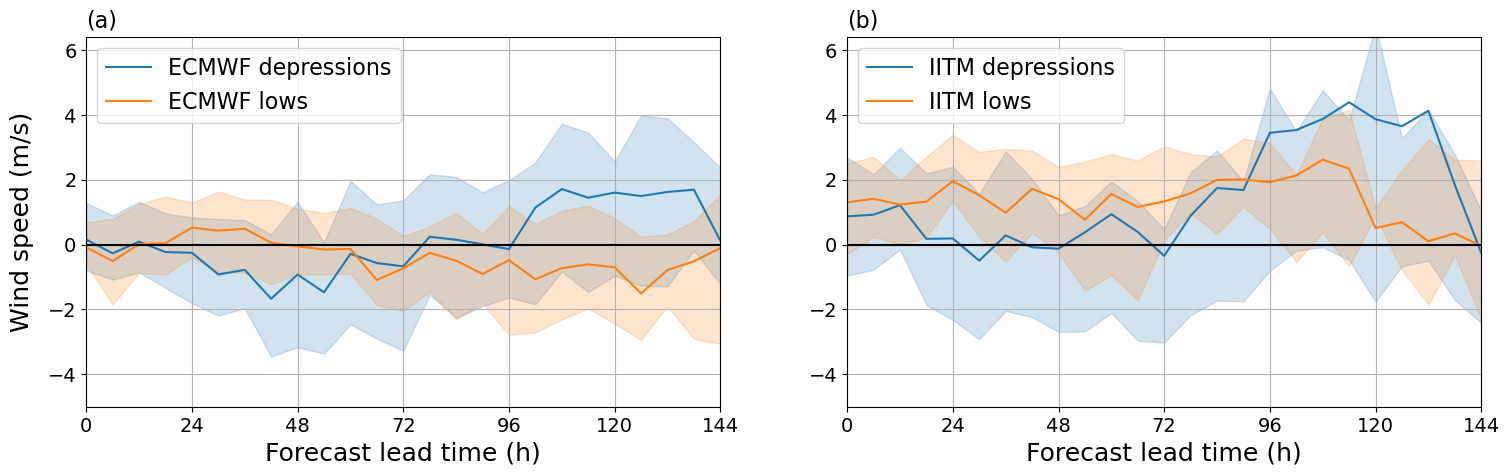

In [38]:
# NOT BEING PUT IN THE MANUSCSRIPT

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,4.8))
two_panel_comparison(ax1, ax2,
                     df1_ax1 = ERA5_ECMWF_deps_windspeed_bias,
                     df2_ax1 = ERA5_ECMWF_lows_windspeed_bias,
                     df1_ax2 = ERA5_IITM_deps_windspeed_bias,
                     df2_ax2 = ERA5_IITM_lows_windspeed_bias,
                     xvalue='ForecastLeadTime', yvalue1='mean', yvalue2='mean',
                     color_var='count',
                     label_df1_ax1='ECMWF depressions', label_df2_ax1='ECMWF lows',
                     label_df1_ax2='IITM depressions', label_df2_ax2='IITM lows',
                     fillbetween_low='<lambda_0>', fillbetween_high='<lambda_1>',
                     title_ax1=None,
                     title_ax2=None,
                     # title_ax1='Forecast Lead Time vs. Mean Track Wind Speed Bias', 
                     # title_ax2='Forecast Lead Time vs. Mean Track Wind Speed Bias',
                     ymin_ax1=-5, ymax_ax1=6.4, 
                     ymin_ax2=-5, ymax_ax2=6.4, 
                     yaxislabel_ax1='Wind speed (m/s)', yaxislabel_ax2='Wind speed bias (m/s)',
                     legend_loc='upper left')

# plt.savefig('Figures/figures_07182022/lead_time_vs_windspeed_bias_depslows.pdf', 
#             format='pdf', bbox_inches='tight')

### check significance wind speed bias

In [39]:
ERA5_ECMWF_windspeed_test = mann_whitney_bias_df(ERA5_ECMWF, 'ecmwf', 'era5', 'MaxSfcWind')
ERA5_IITM_windspeed_test = mann_whitney_bias_df(ERA5_IITM, 'iitm', 'era5', 'MaxSfcWind')

In [40]:
mann_whitney_output(ERA5_ECMWF_windspeed_test, ERA5_IITM_windspeed_test, 'MaxSfcWindBias')

[MannwhitneyuResult(statistic=88306.0, pvalue=8.845910153979892e-13),
 MannwhitneyuResult(statistic=83174.0, pvalue=4.549251193726034e-06),
 MannwhitneyuResult(statistic=50044.0, pvalue=0.0041277469036079505),
 MannwhitneyuResult(statistic=24087.0, pvalue=7.999371838673632e-05),
 MannwhitneyuResult(statistic=9614.0, pvalue=6.11795552991556e-06),
 MannwhitneyuResult(statistic=5337.0, pvalue=0.07659795940635761),
 MannwhitneyuResult(statistic=2236.0, pvalue=0.0705070934959137),
 MannwhitneyuResult(statistic=669.0, pvalue=0.0022622931743565664),
 MannwhitneyuResult(statistic=239.0, pvalue=0.010768232984748763),
 MannwhitneyuResult(statistic=24.0, pvalue=0.051036798638869764)]

# Make the MERRA2 reference plot

This will be a 3 panel plot, with:
- lead time vs. position bias
- lead time vs. intensity bias
- lead time vs. wind speed bias
(no depressions/lows comparison or relative bias comparison)

In [41]:
MERRA2_ECMWF_pos_bias = create_lead_time_vs_position_bias_df(MERRA2_ECMWF, 'ecmwf', 'merra2')
MERRA2_IITM_pos_bias = create_lead_time_vs_position_bias_df(MERRA2_IITM, 'iitm', 'merra2')

In [42]:
MERRA2_ECMWF_intensity_bias, MERRA2_ECMWF_rel_intensity_bias = \
    create_lead_time_vs_bias_df(MERRA2_ECMWF, 'ecmwf', 'merra2', var='PressureDrop', relative=True)

MERRA2_IITM_intensity_bias, MERRA2_IITM_rel_intensity_bias = \
    create_lead_time_vs_bias_df(MERRA2_IITM, 'iitm', 'merra2', var='PressureDrop', relative=True)

In [43]:
MERRA2_ECMWF_windspeed_bias = \
    create_lead_time_vs_bias_df(MERRA2_ECMWF, 'ecmwf', 'merra2', var='MaxSfcWind', relative=False)

MERRA2_IITM_windspeed_bias = \
    create_lead_time_vs_bias_df(MERRA2_IITM, 'iitm', 'merra2', var='MaxSfcWind', relative=False)

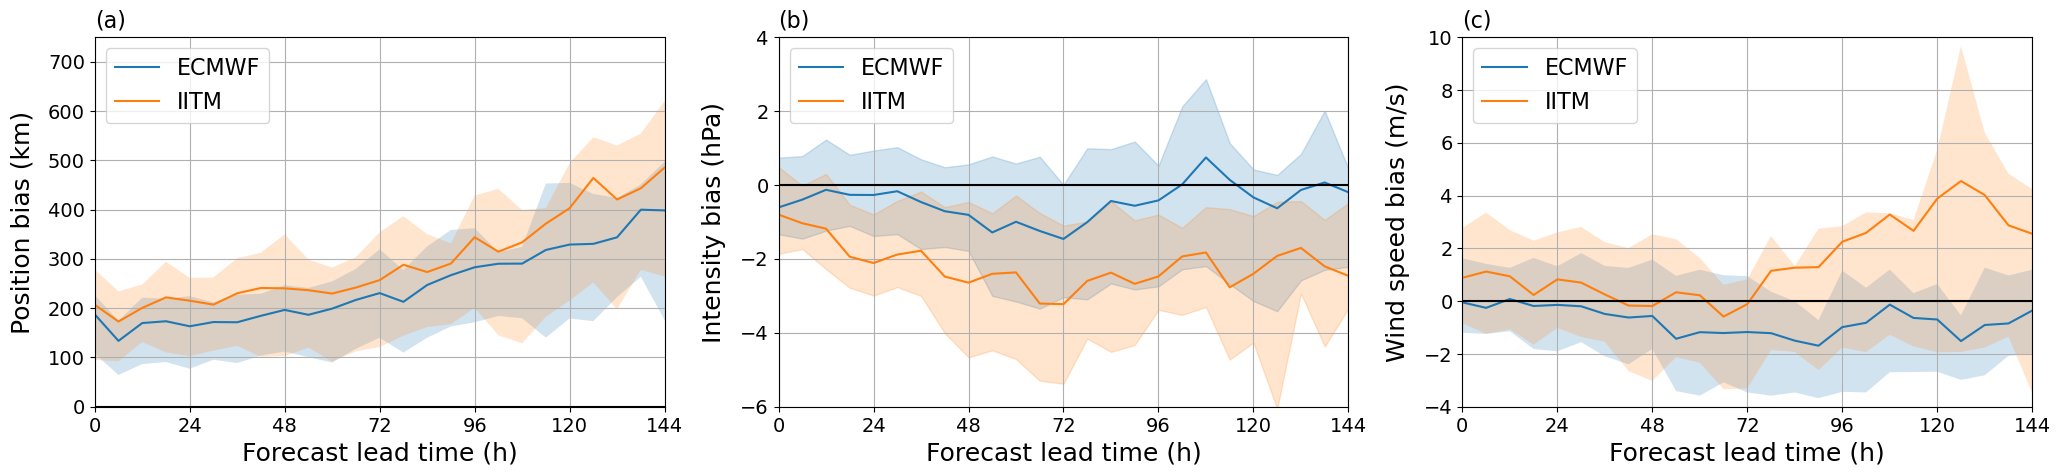

In [76]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,4.8))

# ECMWF vs. IITM, position bias
df1 = MERRA2_ECMWF_pos_bias
df2 = MERRA2_IITM_pos_bias
xvalue = 'ForecastLeadTime'
yvalue = 'mean'
color_var = 'count'
label_model1 = 'ECMWF'
label_model2 = 'IITM'
fillbetween_low = '<lambda_0>'
fillbetween_high = '<lambda_1>'
title_ax1, title_ax2, title_ax3 = None, None, None
ymin, ymax = 0, 750
yaxislabel = 'Position bias (km)'
legend_loc='upper left'

points_model1 = plot_on_ax(ax1, df1, xvalue, yvalue, color_var, label_model1, fillbetween_low,
           fillbetween_high, plot_colors={'color': 'C0'})

points_model2 = plot_on_ax(ax1, df2, xvalue, yvalue, color_var, label_model2, fillbetween_low,
           fillbetween_high, plot_colors={'color': 'C1'})

# plt.colorbar(points_model1, ax=ax1).set_label("Number of Systems") # Suhas said skip
format_ax(ax1, title_ax1, ymin=ymin, ymax=ymax, yaxislabel=yaxislabel, ax_label='(a)',
         legend_loc=legend_loc)

# ECMWF vs. IITM, intensity bias

# the name df1_deps is just the parameter name for the function, doesn't have anything to do with
#    depressions here
df1_deps = MERRA2_ECMWF_intensity_bias 
df1_lows = MERRA2_IITM_intensity_bias
xvalue = 'ForecastLeadTime'
yvalue = 'mean'
color_var = 'count'
label_model1_deps = 'ECMWF'
label_model1_lows = 'IITM'
fillbetween_low = '<lambda_0>'
fillbetween_high = '<lambda_1>'
# title_ax1, title_ax2, title_ax2 = None, None, None
ymin, ymax = -6, 4
yaxislabel = 'Intensity bias (hPa)'

points_model1_deps = plot_on_ax(ax2, df1_deps, xvalue, yvalue, color_var, label_model1_deps, 
                                fillbetween_low, fillbetween_high,
                                plot_colors={'color': 'C0'},
                                fill_colors={'color': 'C0'},
                                divide=100) # Pa to hPa
                                # plot_colors={'color': 'purple'},
                                # fill_colors={'color': 'purple'})

points_model1_lows = plot_on_ax(ax2, df1_lows, xvalue, yvalue, color_var, label_model1_lows, 
                                fillbetween_low, fillbetween_high,
                                plot_colors={'color': 'C1'},
                                fill_colors={'color': 'C1'},
                                divide=100)
                                # plot_colors={'color': 'green'},
                                # fill_colors={'color': 'green'})

# plt.colorbar(points_model1_deps, ax=ax2).set_label("Number of Systems") # Suhas said skip
format_ax(ax2, title_ax2, ymin=ymin, ymax=ymax, yaxislabel=yaxislabel, ax_label='(b)', yax=True,
         legend_loc=legend_loc)

# ECMWF vs. IITM, wind speed bias

df2_deps = MERRA2_ECMWF_windspeed_bias
df2_lows = MERRA2_IITM_windspeed_bias
xvalue = 'ForecastLeadTime'
yvalue = 'mean'
color_var = 'count'
label_model2_deps = 'ECMWF'
label_model2_lows = 'IITM'
fillbetween_low = '<lambda_0>'
fillbetween_high = '<lambda_1>'
# title_ax1, title_ax2, title_ax2 = None, None, None
ymin, ymax = -4, 10
yaxislabel = 'Wind speed bias (m/s)'

points_model2_deps = plot_on_ax(ax3, df2_deps, xvalue, yvalue, color_var, label_model2_deps, 
                                fillbetween_low, fillbetween_high,
                                plot_colors={'color': 'C0'})
                                # fill_colors={'color': 'C2'})
                                # plot_colors={'color': 'purple'},
                                # fill_colors={'color': 'purple'})

points_model2_lows = plot_on_ax(ax3, df2_lows, xvalue, yvalue, color_var, label_model2_lows, 
                                fillbetween_low, fillbetween_high,
                                plot_colors={'color': 'C1'},)
                                # fill_colors={'color': 'C3'})
                                # plot_colors={'color': 'green'},
                                # fill_colors={'color': 'green'})

# plt.colorbar(points_model2_deps, ax=ax3).set_label("Number of Systems") # Suhas said skip
format_ax(ax3, title_ax3, ymin=ymin, ymax=ymax, yaxislabel=yaxislabel, ax_label='(c)', yax=True,
         legend_loc=legend_loc)

# plt.savefig("Figures/figures_08212022/merra2_reference.pdf", format='pdf', bbox_inches='tight')

### checking significance for MERRA2

In [48]:
MERRA2_ECMWF_test = mann_whitney_position_df(MERRA2_ECMWF, 'ecmwf', 'merra2')
MERRA2_IITM_test = mann_whitney_position_df(MERRA2_IITM, 'iitm', 'merra2')

In [49]:
mann_whitney_output(MERRA2_ECMWF_test, MERRA2_IITM_test, 'DistanceBias')

[MannwhitneyuResult(statistic=60516.5, pvalue=0.00011013921832938748),
 MannwhitneyuResult(statistic=56607.5, pvalue=0.00034578586887682486),
 MannwhitneyuResult(statistic=39131.5, pvalue=0.07479140937576667),
 MannwhitneyuResult(statistic=17489.0, pvalue=0.014546746872663708),
 MannwhitneyuResult(statistic=8296.5, pvalue=0.07128314435714198),
 MannwhitneyuResult(statistic=3197.0, pvalue=0.009218245968831165),
 MannwhitneyuResult(statistic=1187.0, pvalue=0.00022801308845073136),
 MannwhitneyuResult(statistic=363.0, pvalue=0.00014159999163832618),
 MannwhitneyuResult(statistic=188.0, pvalue=0.05860432795343473),
 MannwhitneyuResult(statistic=39.0, pvalue=0.07308438961957915)]

In [52]:
MERRA2_ECMWF_intensity_test = mann_whitney_bias_df(MERRA2_ECMWF, 'ecmwf', 'merra2', 'PressureDrop')
MERRA2_IITM_intensity_test = mann_whitney_bias_df(MERRA2_IITM, 'iitm', 'merra2', 'PressureDrop')

In [54]:
mann_whitney_output(MERRA2_ECMWF_intensity_test, MERRA2_IITM_intensity_test, 'PressureDropBias')

[MannwhitneyuResult(statistic=48110.5, pvalue=2.671095713003674e-15),
 MannwhitneyuResult(statistic=39958.0, pvalue=1.044186393831095e-20),
 MannwhitneyuResult(statistic=29287.0, pvalue=1.3428848896727418e-10),
 MannwhitneyuResult(statistic=14337.5, pvalue=4.792857891499821e-07),
 MannwhitneyuResult(statistic=6359.0, pvalue=4.346543186356089e-06),
 MannwhitneyuResult(statistic=2781.0, pvalue=0.00019143830572423975),
 MannwhitneyuResult(statistic=1189.0, pvalue=0.0002368300877344578),
 MannwhitneyuResult(statistic=612.0, pvalue=0.1482709880037078),
 MannwhitneyuResult(statistic=211.0, pvalue=0.14014179625172257),
 MannwhitneyuResult(statistic=59.0, pvalue=0.33899795550648004)]

In [50]:
MERRA2_ECMWF_windspeed_test = mann_whitney_bias_df(MERRA2_ECMWF, 'ecmwf', 'merra2', 'MaxSfcWind')
MERRA2_IITM_windspeed_test = mann_whitney_bias_df(MERRA2_IITM, 'iitm', 'merra2', 'MaxSfcWind')

In [51]:
mann_whitney_output(MERRA2_ECMWF_windspeed_test, MERRA2_IITM_windspeed_test, 'MaxSfcWindBias')

[MannwhitneyuResult(statistic=59810.0, pvalue=4.2578845558402394e-05),
 MannwhitneyuResult(statistic=58536.0, pvalue=0.0033280567182037914),
 MannwhitneyuResult(statistic=38574.0, pvalue=0.04298285978929691),
 MannwhitneyuResult(statistic=15407.0, pvalue=3.4798681239090524e-05),
 MannwhitneyuResult(statistic=6717.0, pvalue=4.8788723732796635e-05),
 MannwhitneyuResult(statistic=2855.0, pvalue=0.0004203107461158338),
 MannwhitneyuResult(statistic=1737.0, pvalue=0.23351216959376586),
 MannwhitneyuResult(statistic=675.0, pvalue=0.34845071276856326),
 MannwhitneyuResult(statistic=214.0, pvalue=0.15477380131477175),
 MannwhitneyuResult(statistic=63.0, pvalue=0.4177707621125947)]